In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

## Creating Necessary Functions

In [7]:
def preprocess(df):
    """
    Preprocess the data removing uncessary data and setting elements to their correct types
    Handle Null values by backward fill null values
    Creating Features for our model training
    """
    if 'Unnamed: 0' in df.columns:
        df.drop(['Unnamed: 0'], axis=1, inplace=True)#remove empty column
    if df.index.name != 'Date':    
        df['Date'] = pd.to_datetime(df['Date']) #update column from string to datetime
        df.set_index('Date', inplace=True) 
        df = df.sort_index()
    df.fillna(method='bfill', inplace=True)
    return df

In [8]:
def feature_engineering(df):
    df['Size_Type'] = df['Size'] * df['Type'] #concatenating the 2 highly correlated features in to one.
    df['Month'] = df.index.month #create a month feature to account for seasonality
    df['Week'] = df.index.isocalendar().week #create a week feature to account for seasonality
    df['Year'] = df.index.year
    df['Quarter'] = df.index.quarter 
    return df

In [9]:
def add_lags(df):
    target_map = df['Weekly_Sales'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta(weeks=1)).map(target_map) #1 week back
    df['lag2'] = (df.index - pd.Timedelta(weeks=5)).map(target_map) #5 weeks back (1 month Approx)
    df['lag3'] = (df.index - pd.Timedelta(weeks=52)).map(target_map) #1 year back
    return df

In [6]:
df = pd.read_csv('../data/walmart_data.csv')
df = preprocess(df)

C:\Users\nmarr\AppData\Local\Temp\ipykernel_27496\3351921570.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


## Training With Cross-Validation

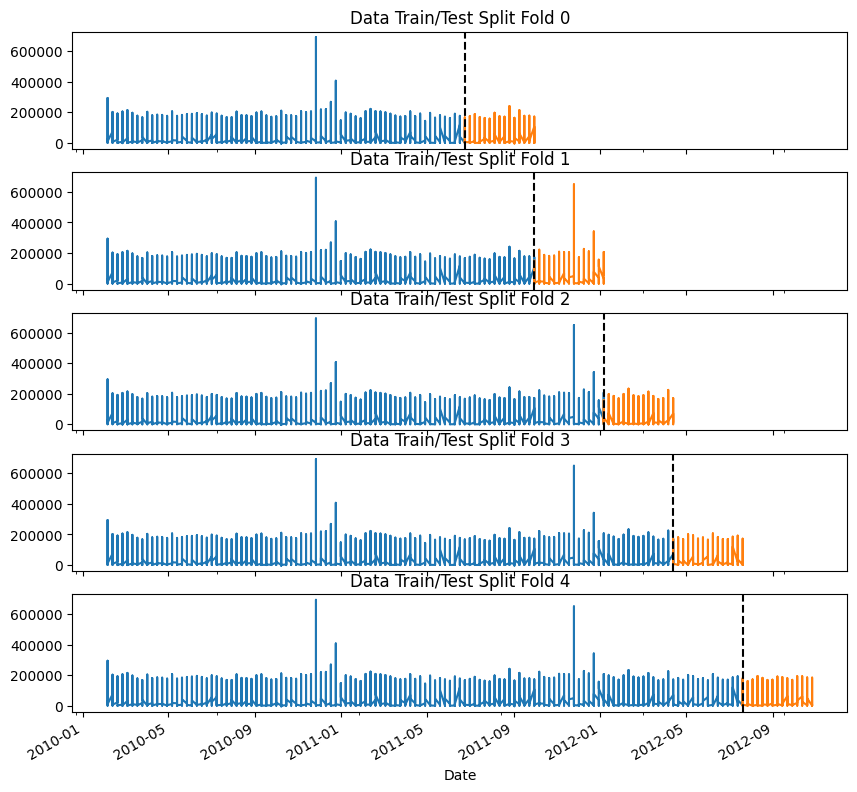

In [7]:
tss = TimeSeriesSplit(n_splits=5, test_size=42000)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Weekly_Sales'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test['Weekly_Sales'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()


In [8]:
df = feature_engineering(df)
df = add_lags(df)
features = ['Size_Type', 'Dept', 'IsHoliday', 'CPI', 'Unemployment', 'Month', 'Week', 'Year', 'Quarter', 'lag1', 'lag2', 'lag3']
target = 'Weekly_Sales'

tss = TimeSeriesSplit(n_splits=5, test_size=42000)
fold = 0
preds, scores = [], {'MAE': [], 'MSE': [], 'RMSE': []}
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000, max_depth=3,
                            early_stopping_rounds=100, objective='reg:squarederror', learning_rate=0.01)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    scores['MAE'].append(mean_absolute_error(y_test, y_pred))
    scores['MSE'].append(mean_squared_error(y_test, y_pred))
    scores['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred)))

[0]	validation_0-rmse:27475.38128	validation_1-rmse:26708.50892
[100]	validation_0-rmse:19106.59884	validation_1-rmse:17834.61176
[200]	validation_0-rmse:16223.82842	validation_1-rmse:14852.32080
[300]	validation_0-rmse:15095.01113	validation_1-rmse:13691.47512
[400]	validation_0-rmse:14182.33424	validation_1-rmse:12785.80326
[500]	validation_0-rmse:13569.35383	validation_1-rmse:12198.31053
[600]	validation_0-rmse:13093.09880	validation_1-rmse:11736.87509
[700]	validation_0-rmse:12706.97317	validation_1-rmse:11363.87865
[800]	validation_0-rmse:12385.72126	validation_1-rmse:11045.26142
[900]	validation_0-rmse:12135.26177	validation_1-rmse:10787.61510
[999]	validation_0-rmse:11892.24561	validation_1-rmse:10541.17800
[0]	validation_0-rmse:27349.61496	validation_1-rmse:31000.83759
[100]	validation_0-rmse:18923.11266	validation_1-rmse:23088.25690
[200]	validation_0-rmse:16019.71746	validation_1-rmse:20098.61621
[300]	validation_0-rmse:14877.23820	validation_1-rmse:18874.54438
[400]	validati

In [9]:
mean_mae = np.mean(scores['MAE'])
mean_mse = np.mean(scores['MSE'])
mean_rmse = np.mean(scores['RMSE'])

print(f'Fold Scores - Mean Absolute Error: {scores["MAE"]}')
print(f'Fold Scores - Mean Squared Error: {scores["MSE"]}')
print(f'Fold Scores - Root Mean Absolute Error: {scores["RMSE"]}')
print(f'Mean Absolute Error: {mean_mae}')
print(f'Mean Squared Error: {mean_mse}')
print(f'Root Mean Absolute Error: {mean_rmse}')



Fold Scores - Mean Absolute Error: [6721.864306887601, 8384.37863596107, 6985.644997796057, 7101.3671677831, 6765.087995254268]
Fold Scores - Mean Squared Error: [111116433.74510373, 246832211.7112573, 124441547.16644703, 121473151.8598468, 110170005.74935496]
Fold Scores - Root Mean Absolute Error: [10541.178005569573, 15710.894682075152, 11155.337160590308, 11021.485918869868, 10496.190058747743]
Mean Absolute Error: 7191.66862073642
Mean Squared Error: 142806670.04640198
Root Mean Absolute Error: 11785.017165170528


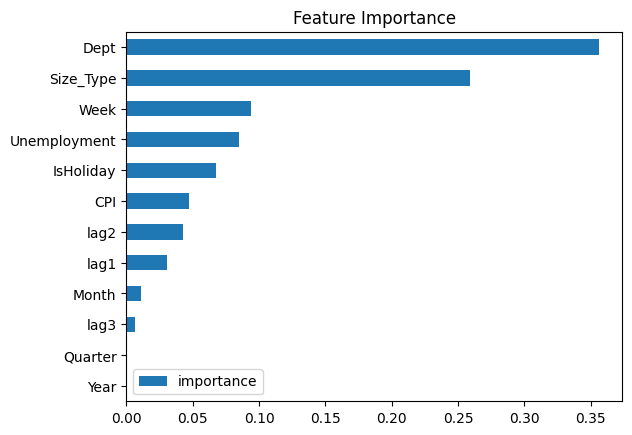

In [10]:
feature_importance = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_,
                                  columns=['importance'])
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

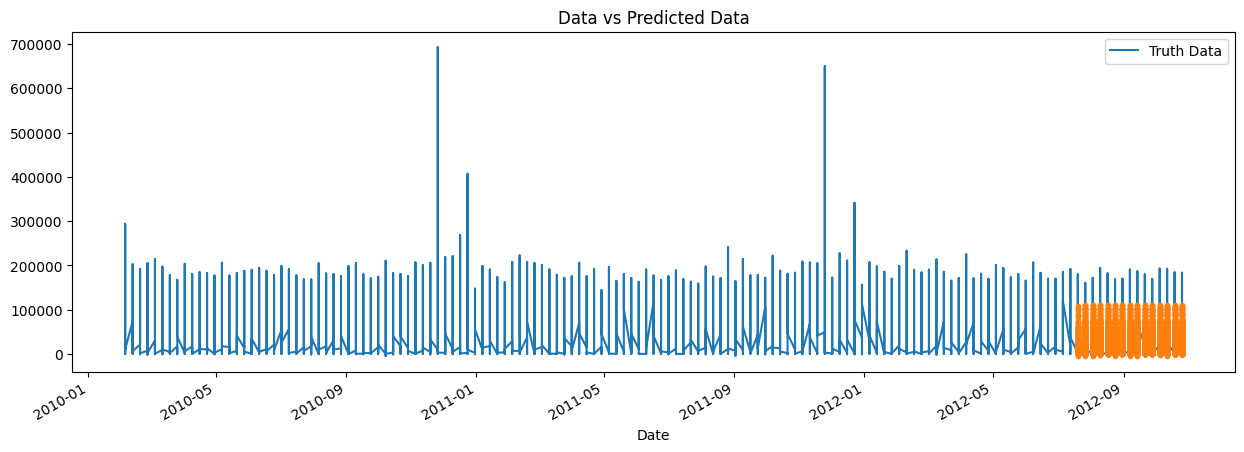

In [11]:
prediction = reg.predict(X_test)
prediction_series = pd.Series(prediction, index=X_test.index)
ax = df['Weekly_Sales'].plot(figsize=(15, 5), label='Truth Data')
prediction_series.plot(ax=ax, style='.')
plt.legend()
plt.title('Data vs Predicted Data')
plt.show()

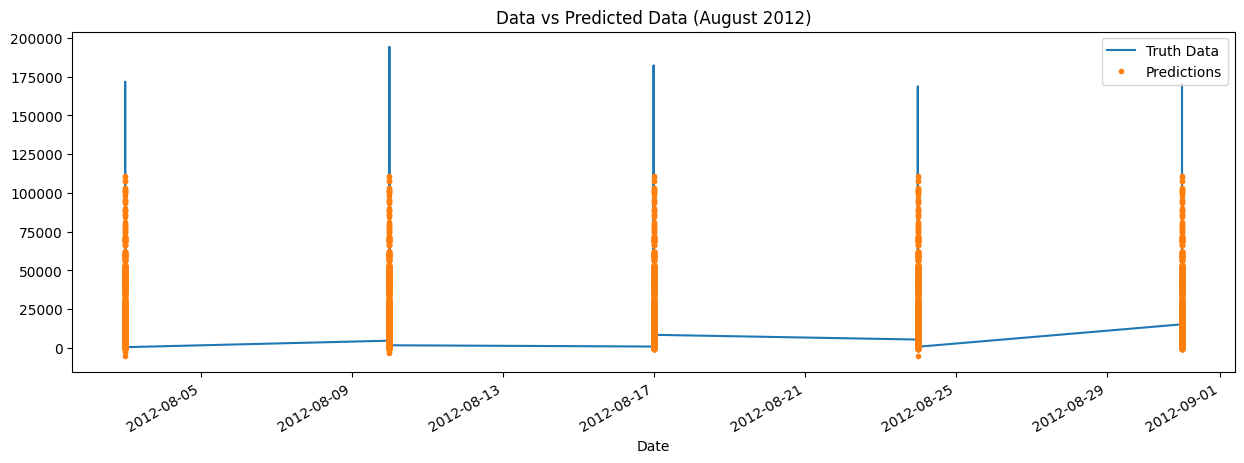

In [12]:
# Filter data from 2012-07 onwards
start_date = '2012-08-01'
end_date = '2012-09-01'
filtered_df = df.loc[start_date:end_date]
filtered_prediction_series = prediction_series.loc[start_date:end_date]

ax = filtered_df['Weekly_Sales'].plot(figsize=(15, 5), label='Truth Data')
filtered_prediction_series.plot(ax=ax, style='.', label='Predictions')

plt.legend()
plt.title('Data vs Predicted Data (August 2012)')
plt.show()

## Predicting On Future Data

In [10]:
df = pd.read_csv('../data/walmart_data.csv')
df = preprocess(df)
df = feature_engineering(df)
df = add_lags(df)

features = ['Size_Type', 'Dept', 'IsHoliday', 'CPI', 'Unemployment', 'Month', 'Week', 'Year', 'Quarter', 'lag1', 'lag2', 'lag3']
target = 'Weekly_Sales'

X_all = df[features]
y_all = df[target]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=500, objective='reg:squarederror', learning_rate=0.01)
reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=200)

C:\Users\nmarr\AppData\Local\Temp\ipykernel_28232\3351921570.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


[0]	validation_0-rmse:27548.23656
[200]	validation_0-rmse:11640.80069
[400]	validation_0-rmse:9335.53989
[499]	validation_0-rmse:8763.91415


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
df.index.max()

Timestamp('2012-10-26 00:00:00')

In [12]:
future = pd.date_range('2012-10-26', '2013-02-26', freq='1W')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = feature_engineering(df_and_future)
df_and_future = add_lags(df_and_future)
df_and_future.tail()

,Store,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Size,Size_Type,Month,Week,Year,Quarter,lag1,lag2,lag3,isFuture
2013-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,4,2013,1,NaN,NaN,NaN,True
2013-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,5,2013,1,NaN,NaN,NaN,True
2013-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,6,2013,1,NaN,NaN,NaN,True
2013-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,7,2013,1,NaN,NaN,NaN,True
2013-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,8,2013,1,NaN,NaN,NaN,True


In [18]:
future_w_features = df_and_future.query('isFuture').copy()
future_w_features['Size_Type'] = 247474
future_w_features['Dept'] = 44
future_w_features['IsHoliday'] = df.loc['2011-10-26':'2012-02-26', 'IsHoliday'].mean()
future_w_features['CPI'] = df.loc['2011-10-26':'2012-02-26', 'CPI'].mean()
future_w_features['Unemployment'] = df.loc['2011-10-26':'2012-02-26', 'Unemployment'].mean()
future_w_features.head()

,Store,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Size,Size_Type,Month,Week,Year,Quarter,lag1,lag2,lag3,isFuture
2012-10-28,NaN,0.168038,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,247474,10,43,2012,4,NaN,NaN,NaN,True
2012-11-04,NaN,0.168038,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,247474,11,44,2012,4,NaN,NaN,NaN,True
2012-11-11,NaN,0.168038,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,247474,11,45,2012,4,NaN,NaN,NaN,True
2012-11-18,NaN,0.168038,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,247474,11,46,2012,4,NaN,NaN,NaN,True
2012-11-25,NaN,0.168038,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,247474,11,47,2012,4,NaN,NaN,NaN,True


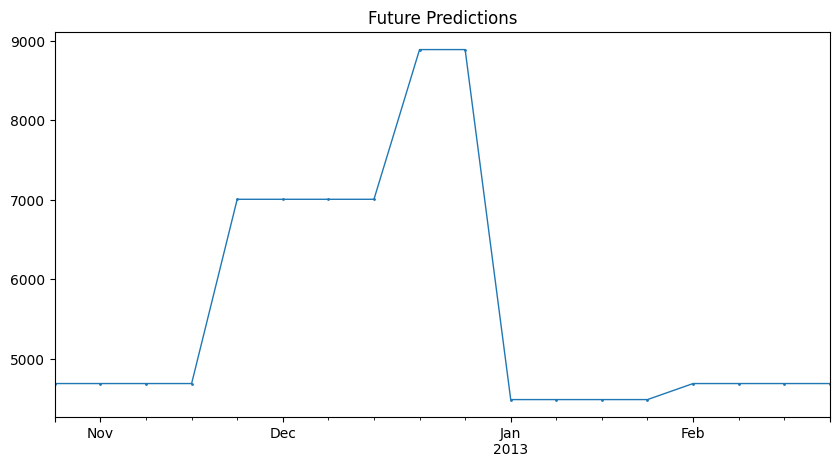

In [19]:
future_w_features['pred'] = reg.predict(future_w_features[features])
future_w_features['pred'].plot(figsize=(10,5), ms=1, lw=1, title='Future Predictions', marker='o', linestyle='-')
plt.show()

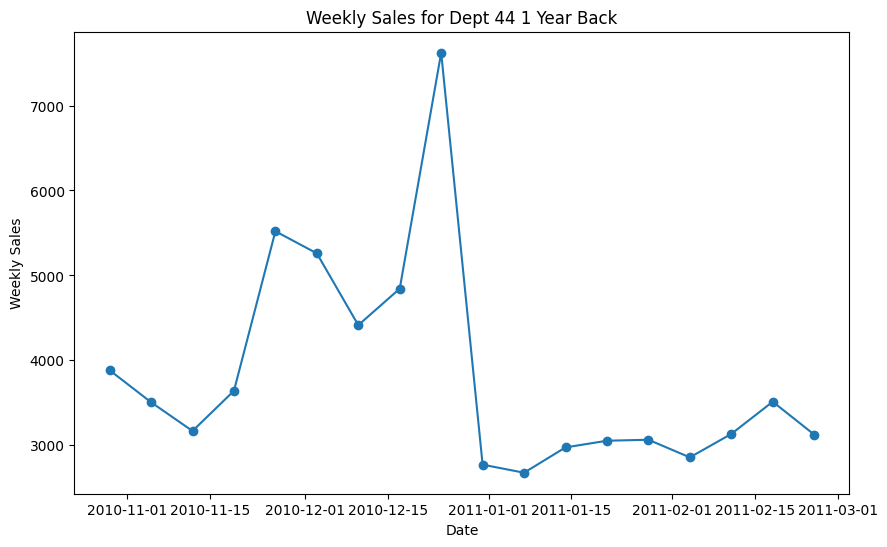

In [17]:
# Applying the mask
mask = (df.index >= '2010-10-26') & (df.index <= '2011-02-26') & (df['Dept'] == 44) & (df['Size_Type']==247474)
selected_data = df.loc[mask]
# print(selected_data)

plt.figure(figsize=(10, 6))
plt.plot(selected_data.index, selected_data['Weekly_Sales'], marker='o', linestyle='-')
plt.title('Weekly Sales for Dept 44 1 Year Back')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()